In [251]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import seaborn as sns
import re
from sklearn.feature_extraction import DictVectorizer
sns.set(color_codes=True)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [191]:
PATH_TO_FOLDER = "../Yelp/Data/"
BUSINESS = "part_businesses.csv"
TIPS = "part_tips.csv"
USERS = "part_users.csv"
REVIEWS = "part_reviews.csv"

In [192]:
reviews_df = pd.read_csv(PATH_TO_FOLDER+REVIEWS)
business_df = pd.read_csv(PATH_TO_FOLDER+BUSINESS)
tips_df = pd.read_csv(PATH_TO_FOLDER+TIPS)

tips_df = tips_df[["business_id", "date", "likes", "user_id"]] # Удаляем текст


business_df = business_df[["business_id", "city"]]
business_df.columns = ["business_id", "business_city"]

In [193]:
tips_df.head(1)

,business_id,date,likes,user_id
0,mVHrayjG3uZ_RLHkLj-AMg,2013-01-06,0,EZ0r9dKKtEGVx2CdnowPCw


In [194]:
reviews_df.head(1)

,business_id,date,review_id,stars,text,user_id,vote_cool,vote_funny,vote_useful
0,vcNAWiLM4dR7D2nwwJ7nCA,2010-03-22,RF6UnRTtG7tWMcrO2GEoAg,2,"Unfortunately, the frustration of being Dr. Go...",H1kH6QZV7Le4zqTRNxoZow,0,0,2


Посмотрим, как распределены оценки за ревью

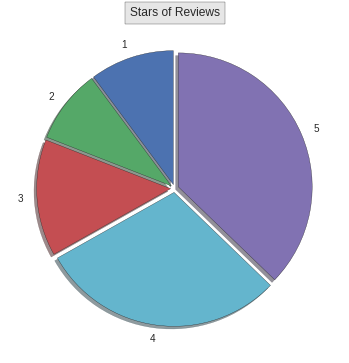

In [195]:
figure(3, figsize=(6,6))
stars_count = reviews_df.groupby("stars")["stars"].count()
labels = ["1", "2", "3", "4", "5"]
explode=(0.03, 0.03, 0.03, 0.03, 0.03)
pie(start_count, labels=labels, shadow=True, startangle=90, explode=explode)
plt.title('Stars of Reviews', bbox={'facecolor':'0.9', 'pad':5})
plt.show()

Видно, что количество положительных оценок превосходит количество отрицательных




Посчитаем количество слов. Построим график, который покажет, как оценка за рецензию зависит от количества слов в рецензии.

In [173]:
def get_count_of_words(text):
    return text.count(' ')+1

reviews_df["count_of_words"] = reviews_df.text.map(lambda s: get_count_of_words(s))

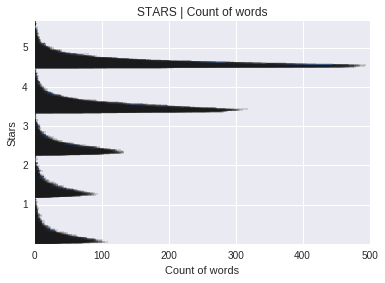

In [174]:
a = reviews_df.groupby(["stars", "count_of_words"]).count_of_words.count()
step = reviews_df["count_of_words"].max()
pd.DataFrame(a).plot(kind='barh')
frame = pylab.gca()
pylab.title("STARS | Count of words")
pylab.xlabel("Count of words")
pylab.ylabel("Stars")
frame.axes.get_yaxis().set_ticks([])
frame.legend_.remove()

plt.yticks([step*(i+1)/2 for i in range(5)], ["1","2","3","4","5"], rotation='horizontal');
plt.show()

На это графике видно, что если человее написал в своем обзоре больше 150 слов, то он, однозначно, получит положительную за нее оценку.

Считаем ревью людей по городам

In [196]:
reviews_df = reviews_df.merge(business_df, on='business_id', left_index=True, right_index=False)

In [197]:
# Сколько раз для какого города пользователи делали обзоры
business_city_count = pd.DataFrame(reviews_df.groupby(["user_id", "business_city"])["business_city"].count())
business_city_count.columns = ["reviews_for_city"]
business_city_count.reset_index(inplace=True)  

In [198]:
# Общее количество ревью для каждого пользователя
review_count = pd.DataFrame(reviews_df.groupby("user_id")["user_id"].count())
review_count.columns = ["reviews_count"]
review_count.reset_index(inplace=True)  

Построим гистограмму людей по количеству людей по ревью

19


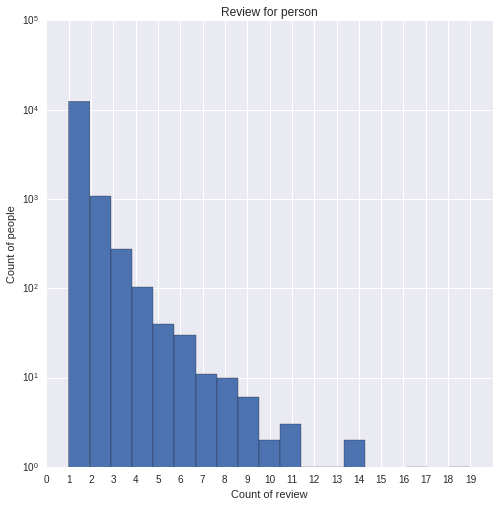

In [199]:
review_count_array = review_count["reviews_count"].as_matrix()
max_ = max(review_count_array)
print max_
plt.figure(figsize=(8,8))
plt.hist(review_count_array, bins=max_)
plt.yscale('log')
plt.xticks([i for i in range(max_+1)])
plt.title('Review for person')
plt.xlabel('Count of review')
plt.ylabel('Count of people')
review_count_array = 0

In [200]:
user_city_df = review_count.merge(business_city_count, on='user_id', left_index=True, right_index=False)

In [201]:
user_city_df.head(1)

,user_id,reviews_count,business_city,reviews_for_city
0,--65q1FpAL_UQtVZ2PTGew,4,Phoenix,3


In [202]:
def is_only_one_city(count1, count2):
    return 1 if (count1==count2) else 0
    
user_city_df["is_only_one_city"] = user_city_df.apply(lambda s: is_only_one_city(s["reviews_count"], s["reviews_for_city"]), axis=1)

Сколько людей писали review только в одном городе, а сколько в нескольких

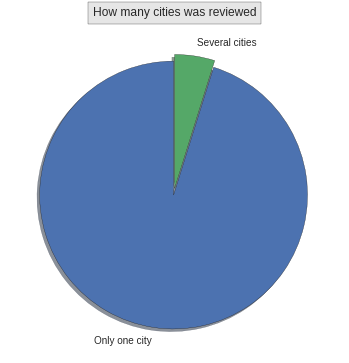

In [203]:
figure(3, figsize=(6,6))
count_of_users = user_city_df[["user_id", "is_only_one_city"]]
count_of_users = count_of_users.drop_duplicates()


count_uniq = count_of_users["is_only_one_city"].value_counts()

labels = ["Only one city", "Several cities"]
explode=(0.05, 0)
pie(count_uniq, labels=labels, shadow=True, startangle=90, explode=explode)
plt.title('How many cities was reviewed', bbox={'facecolor':'0.9', 'pad':5})
plt.show()

count_of_users = 0

Сделаем тоже самое для TIPS

In [204]:
tips_city_df = tips_df.merge(business_df, on='business_id', left_index=True, right_index=False)

In [212]:
# Сколько раз для какого города пользователи делали tips
tips_city_count = pd.DataFrame(tips_city_df.groupby(["user_id", "business_city"])["business_city"].count())
tips_city_count.columns = ["tips_for_city"]
tips_city_count.reset_index(inplace=True)  

In [214]:
# Общее количество tips для каждого пользователя
tips_count = pd.DataFrame(tips_city_df.groupby("user_id")["user_id"].count())
tips_count.columns = ["tips_count"]
tips_count.reset_index(inplace=True)  

In [216]:
tips_city_df = tips_city_count.merge(tips_count, on='user_id', left_index=True, right_index=False)

In [218]:
def is_only_one_city(count1, count2):
    return 1 if (count1==count2) else 0
    
tips_city_df["is_only_one_city"] = tips_city_df.apply(lambda s: is_only_one_city(s["tips_for_city"], s["tips_count"]), axis=1)
tips_city_df.head()

,user_id,business_city,tips_for_city,tips_count,is_only_one_city
0,--65q1FpAL_UQtVZ2PTGew,Las Vegas,1,2,0
0,--65q1FpAL_UQtVZ2PTGew,Phoenix,1,2,0
1,--f43ruUt7LBeB3aU74z-w,Charlotte,1,1,1
2,-2OWhxjHGfjArURE6ABhJQ,Las Vegas,1,1,1
3,-2jevGd5B6dqAT7AwBW6lA,Phoenix,1,1,1


27


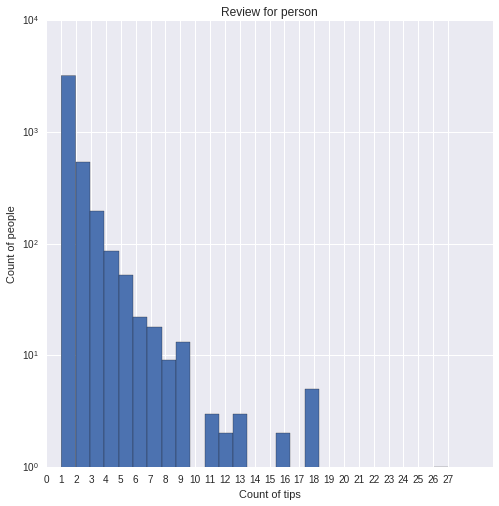

In [224]:
tips_count_array = tips_city_df["tips_count"].as_matrix()
max_ = max(tips_count_array)
print max_
plt.figure(figsize=(8,8))
plt.hist(tips_count_array, bins=max_)
plt.yscale('log')
plt.xticks([i for i in range(max_+1)])
plt.title('Review for person')
plt.xlabel('Count of review')
plt.ylabel('Count of people')
review_count_array = 0

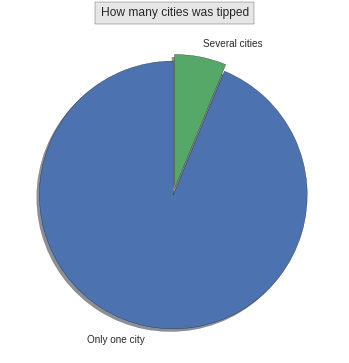

In [222]:
figure(3, figsize=(6,6))
count_of_users = tips_city_df[["user_id", "is_only_one_city"]]
count_of_users = count_of_users.drop_duplicates()


count_uniq = count_of_users["is_only_one_city"].value_counts()

labels = ["Only one city", "Several cities"]
explode=(0.05, 0)
pie(count_uniq, labels=labels, shadow=True, startangle=90, explode=explode)
plt.title('How many cities was tipped', bbox={'facecolor':'0.9', 'pad':5})
plt.show()

count_of_users = 0

Построим облако тегов для Tips и Reviews

In [305]:
def get_words(text):
    """returns list of words"""
    text = re.sub(r"_+", '', text) # Удаляем __, они, почему-то, входят в \w
    text = re.sub("\w*\d\w*", "", text) # Удаляем все цифры и слова с цифрами
    array = re.findall(r'[\w]+', text) # Выделяем слова
    return array


def get_tokens(words):
    """returns list of tokens"""
    stop_words = stopwords.words('english')
    wordnet_lemmatizer = WordNetLemmatizer()
    
    lems = []
    for w in words:
        w = w.lower()
        if w not in stop_words:
            w = wordnet_lemmatizer.lemmatize(w)
            lems.append(w)
    return lems


def get_df_tokens(df):
    STEP = 2000
    df_step = df[df.index<STEP]
    i = 1
    
    row = {}
    while(len(df_step)):
        text_array = df_step["text"]
        text_array =  text_array.as_matrix()
        for text in text_array:
            text_array = get_words(text)
            tokens = get_tokens(text_array)
            
            for token in tokens:
                if token in row:
                    row[token] += 1
                else:
                    row[token] = 1
                    
        df_step = df[(df.index >= i*STEP) & (df.index<(i+1)*STEP)]
        i+=1
    return row


def draw_tag_cloud(tokens):
        
    list_of_couple = []
    for key, value in tokens.iteritems():
        list_of_couple.append((key, value))
    
    list_of_couple.sort(key=lambda tup: tup[1], reverse=True)
    wordcloud = WordCloud(background_color="white", max_words=200000, width=1000, height=700).generate_from_frequencies(list_of_couple)
    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

    


Построим облако тегов для TIPS

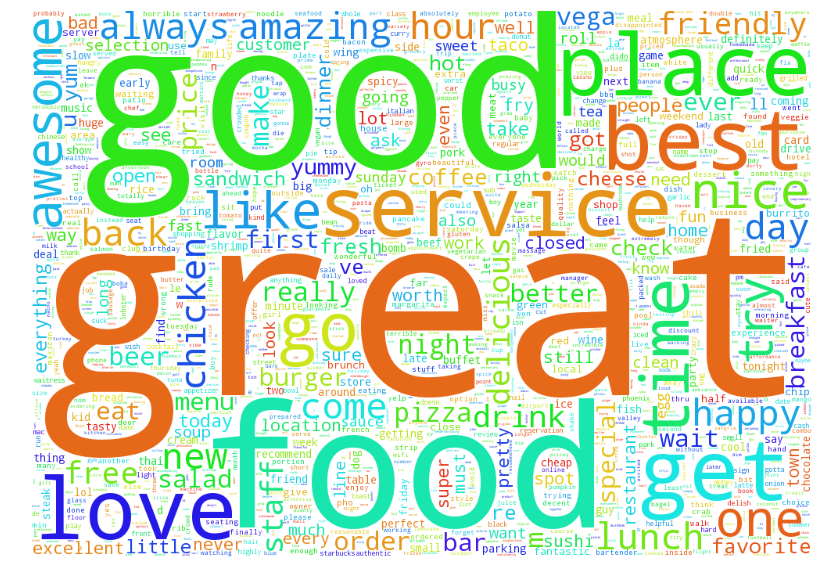

In [301]:
tokens = get_df_tokens(tips_df)
draw_tag_cloud(tokens)

In [ ]:
tokens = get_df_tokens(tips_df)
draw_tag_cloud(tokens)

Построим облако тегов для REVIEW

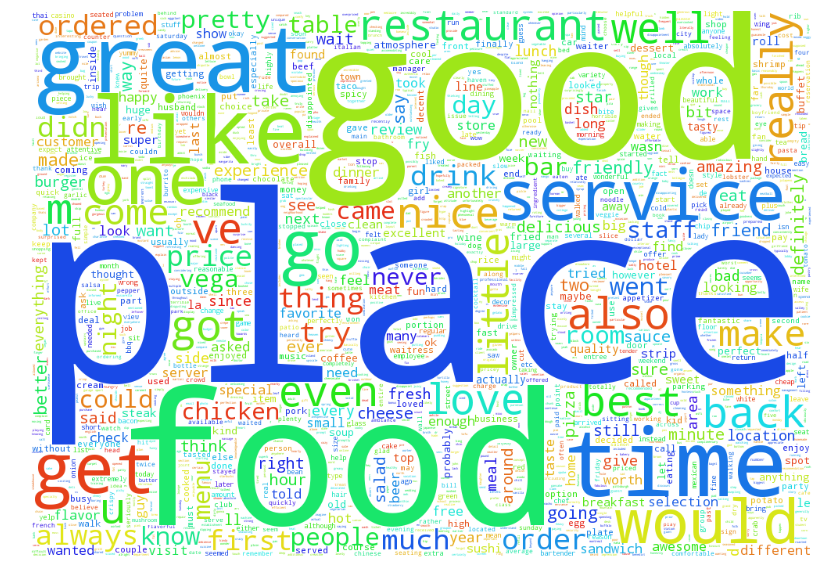

In [306]:
reviews_df = pd.read_csv(PATH_TO_FOLDER+REVIEWS)
tokens = get_df_tokens(reviews_df)
draw_tag_cloud(tokens)

In [ ]:
star_and_count = reviews_df.groupby(["stars", "count_of_words"]).count_of_words.count()
star_and_count = pd.DataFrame(star_and_count)
star_and_count.columns = ["freq"]
star_and_count.reset_index(inplace=True)

STEPS_COUNT = 40
max_ = star_and_count.stars.max()
step = max_/STEPS_COUNT+1

hist_array = []

for star in range(star_and_count.stars.max()):
    star_i = star_and_count[star_and_count["stars"]==star+1]
    star_i["label"] = pd.cut(star_i["count_of_words"], [i*25 for i in range(60)])
    
    count_of_words_in_interval = star_i.groupby("label")["freq"].sum().as_matrix()
    count_of_words_in_interval = np.nan_to_num(count_of_words_in_interval)
    hist_array.append(count_of_words_in_interval)
    print len(count_of_words_in_interval)

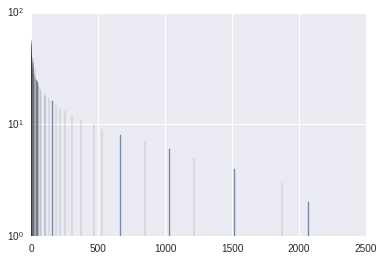

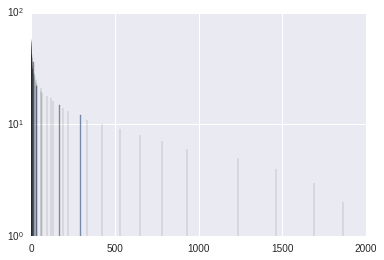

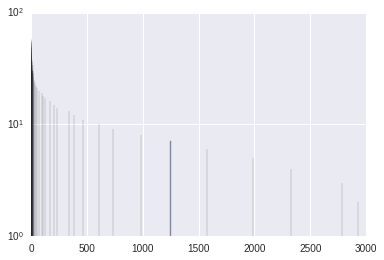

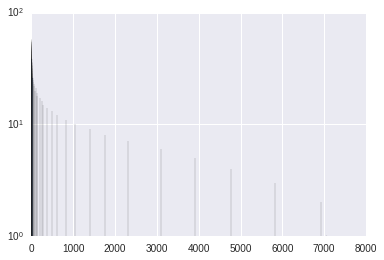

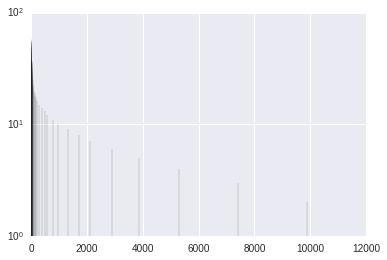

In [189]:
for hi in hist_array:
    plt.bar(hi, range(len(hi)), alpha=0.6)
    plt.yscale('log')
    plt.show()

#len(hi)
#star_i["label"].unique()

In [182]:
len(hi)

59

In [147]:
a1["label"] = pd.cut(a1["count_of_words"], [i*25 for i in range(50)])

/home/popka/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [152]:
s = pd.cut(a1["count_of_words"], [i*25 for i in range(50)])

In [156]:
s.unique()

[(0, 25], (25, 50], (50, 75], (75, 100], (100, 125], ..., (900, 925], (925, 950], (950, 975], (975, 1000], (1000, 1025]]
Length: 41
Categories (41, object): [(0, 25] < (25, 50] < (50, 75] < (75, 100] ... (925, 950] < (950, 975] < (975, 1000] < (1000, 1025]]

In [148]:
np.nan_to_num(a1.groupby("label")["freq"].sum().as_matrix())

array([ 1153.,  2190.,  2070.,  1872.,  1517.,  1217.,  1032.,   851.,
         666.,   531.,   467.,   372.,   303.,   250.,   213.,   182.,
         158.,   130.,   105.,   105.,    73.,    63.,    50.,    49.,
          46.,    39.,    30.,    29.,    22.,    19.,     8.,    15.,
          27.,    10.,    10.,    14.,    14.,    14.,    11.,     7.,
           5.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.])

Идеи:
* Длина текста + оценка (зависимости длины текста от оценки)
* Облако тегов из текста. Можно для разного количества звезд.
* Кто чаще получает положительные оценки - иностранцы или нет


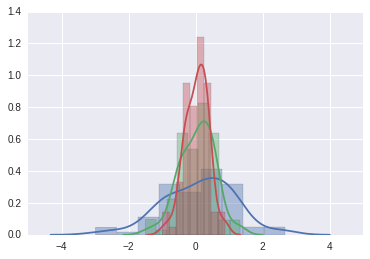

In [7]:
x = np.random.normal(size=100)
sns.distplot(x);
sns.distplot(x/2);
sns.distplot(x/3);

In [7]:
pd.cut

<function pandas.tools.tile.cut>

In [62]:
d = pd.DataFrame(a)
d.columns = ["words_count"]

In [70]:
d.reset_index(inplace=True)
d = d[d["stars"]==1]

SyntaxError: unexpected EOF while parsing (<ipython-input-69-5a06a4a4e17d>, line 1)

In [26]:
def get_tokens(words):
    """returns list of tokens"""
    stop_words = stopwords.words('english')
    wordnet_lemmatizer = WordNetLemmatizer()
    
    lems = []
    for w in words:
        w = w.lower()
        if w not in stop_words:
            w = wordnet_lemmatizer.lemmatize(w)
            lems.append(w)
    return lems

In [50]:
d.groupby(pd.cut(d["words_count"], bins=[i*25 for i in range(10)])).count()

,stars,count_of_words,words_count
words_count,,,
"(0, 25]",2524,2524,2524
"(25, 50]",391,391,391
"(50, 75]",293,293,293
"(75, 100]",182,182,182
"(100, 125]",106,106,106
"(125, 150]",54,54,54
"(150, 175]",36,36,36
"(175, 200]",32,32,32
"(200, 225]",27,27,27


In [35]:
s = pd.DataFrame(a)
s.columns = ["freq"]
s.reset_index(inplace=True)

,stars,count_of_words,freq
0,1,1,32
1,1,2,12
2,1,3,26
3,1,4,30
4,1,5,22
5,1,6,30
6,1,7,27
7,1,8,33
8,1,9,34
9,1,10,41


In [49]:
m = s[s["stars"]==1]
#m.groupby(pd.cut(s["count_of_words"], bins=[i*25 for i in range(10)])).count()

,stars,count_of_words,freq
count_of_words,,,
"(0, 25]",25,25,25
"(25, 50]",25,25,25
"(50, 75]",25,25,25
"(75, 100]",25,25,25
"(100, 125]",25,25,25
"(125, 150]",25,25,25
"(150, 175]",25,25,25
"(175, 200]",25,25,25
"(200, 225]",25,25,25


In [53]:
for i in range(5):
    print s[s["stars"]==i+1].groupby(pd.cut(s["count_of_words"], bins=[i*25 for i in range(10)]))

ValueError: Categorical dtype grouper must have len(grouper) == len(data)